# Ensamble
To create an ensamble model:
- save validation set and train set into model_state
- read validation set from model_state
- split validation set into 2 parts
- try different combinations of the models in loop on the first part of the validation set
- use the second part of the validation set to evaluate the performance of the combination

In [9]:
# load validation set from "../data/model_state/val_df.csv"

import pandas as pd
import numpy as np

val_df = pd.read_csv("../data/model_state/val_df.csv")

users = val_df["user"].values
items = val_df["item"].values
ratings = val_df["rating"].values

print(type(users), users.shape)

<class 'numpy.ndarray'> (12001,)


In [10]:
# split data into val and test
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.5
users_val, users_test, items_val, items_test, ratings_val, ratings_test = train_test_split(users, items, ratings, test_size=TEST_SIZE)

print(type(users_val), users_val.shape)

<class 'numpy.ndarray'> (6000,)


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import torch
from models import LightGCNPlus, load_best_val_model
from postprocess import create_submission_matrix, load_means_stds, reverse_standardize, to_submission_format
from load import load_submission_users_items

DEVICE = torch.device('mps' if torch.cuda.is_available() else 'cpu')

# Model IDs and configurations
model_configs = [
    (28, 5, (6, )),
    (28, 4, (2,)),
    (28, 5, (6, 1)),
    (28, 4, (3,)),
    (28, 4, (4,)),
    (28, 4, (5,)),
    (28, 4, (3, 1)),
    (28, 5, (6, 1)),
    (28, 4, (4, 1)),    # 0.9544785051674509
    # (28, 4, (6,))  # 0.9544688824398718
]


def load_and_predict(model_class, config_id, users, items):
    ID = f"{config_id[0]}_{config_id[1]}_{str(config_id[2])}"
    model = load_best_val_model(model_class, ID)
    raw_pred_ratings = model.get_ratings(users, items).detach().cpu().numpy()
    raw_submission_matrix = create_submission_matrix(raw_pred_ratings, users, items)
    means, stds = load_means_stds(ID)
    submission_matrix = reverse_standardize(raw_submission_matrix, means, stds)
    pred_ratings = submission_matrix[users, items]
    pred_ratings = np.clip(pred_ratings, 1, 5)
    return pred_ratings

# Load and predict with each model for validation and test sets
pred_ratings_list_val = [load_and_predict(LightGCNPlus, config, users_val, items_val) for config in model_configs]
pred_ratings_list_test = [load_and_predict(LightGCNPlus, config, users_test, items_test) for config in model_configs]

# Define the objective function for optimization
def objective(weights, predictions, true_ratings):
    ensemble_preds = np.sum(weights[:, None] * predictions, axis=0)
    mse = mean_squared_error(true_ratings, ensemble_preds)
    return mse

# Initial weights (equal weights)
initial_weights = np.ones(len(pred_ratings_list_val)) / len(pred_ratings_list_val)

# Bounds for the weights (they should be between 0 and 1)
bounds = [(0, 1) for _ in range(len(pred_ratings_list_val))]

# Constraints (weights should sum to 1)
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Find the best weights using the validation set
result = minimize(objective, initial_weights, args=(np.array(pred_ratings_list_val), ratings_val), bounds=bounds, constraints=constraints, method='SLSQP')

best_weights = result.x
print(f"Best weights found: {best_weights}")

# Evaluate the best weights on the test set
ensemble_pred_ratings_test = np.sum(best_weights[:, None] * np.array(pred_ratings_list_test), axis=0)
mse_test = mean_squared_error(ratings_test, ensemble_pred_ratings_test)
print(f"Test MSE: {mse_test}")

# Load submission users and items
submission_users, submission_items = load_submission_users_items()

# Load and predict with each model for the submission set
pred_ratings_list_submission = [load_and_predict(LightGCNPlus, config, submission_users, submission_items) for config in model_configs]

# Get final ensemble predictions for submission
ensemble_pred_ratings_submission = np.sum(best_weights[:, None] * np.array(pred_ratings_list_submission), axis=0)
ensemble_pred_ratings_submission = np.clip(ensemble_pred_ratings_submission, 1, 5)

# Create the submission dataframe
submission = to_submission_format(submission_users, submission_items, ensemble_pred_ratings_submission)

# Save the submission to a CSV file
submission.to_csv('../data/submission_data/submission.csv', index=False)
print("Submission saved to '../data/submission_data/submission.csv'")

Best weights found: [0.25085255 0.18017502 0.06760116 0.20603879 0.00458184 0.10751495
 0.07237354 0.06760134 0.04326082]
Test MSE: 0.9544785051674509
Submission saved to '../data/submission_data/submission.csv'


min: -2.4911702
max: 1.6713597
mean: 0.021086179


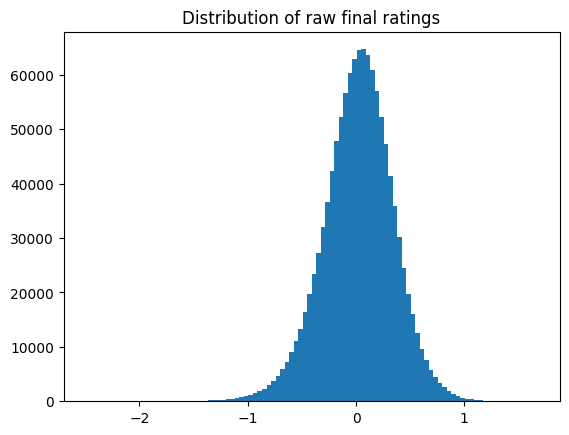

min: 0.5001405918203505
max: 5.672306683219501
mean: 3.879019421591461
count_over_5: 7727
count_under_1: 27

min: 1.0
max: 5.0
mean: 3.8783547326809154


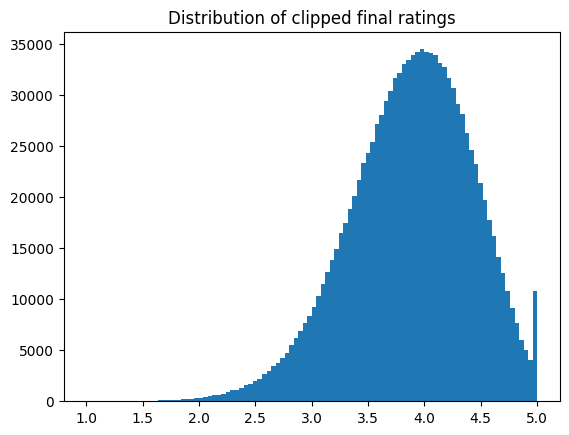

In [ ]:
from postprocess import postprocess
from models import LightGCNPlus
# K=28, L=5, C=(6, 1)
# K=28, L=4, C=(2,)
# K=28, L=4, C=(5,)
K=28
L=4
C=(2,)
ID = str(K) + "_" + str(L) + "_" + str(C)
postprocess(LightGCNPlus, ID)